In [1]:
# イジング模型を選択'square'or'triangular'
Ising_model = 'square'

# ニューラルネットワークを選択'FCN'or'CNN'
neural_network = 'FCN'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import prm
from torch.utils.data import DataLoader, TensorDataset

In [3]:
N_dis = prm.N_dis   # 捨てる個数
N_trj = prm.N_trj   # トータルのアップデート回数
N_sav = prm.N_sav
prm_list = prm.prm_list
prm_list_tri = prm.prm_list_tri


In [4]:
nconf = 90     # 各ベータでの配位の生成

betacr = 0.440686
data = []
labels = []
betas = []

betacr_tri = 0.2747
data_tri = []
labels_tri = []
betas_tri = []

nprm = len(prm_list)

# 正方イジング模型の配位データ
for ibeta in range(nprm):
    beta = prm_list[ibeta][0]
    fname = prm_list[ibeta][3]
    for itrj in range(nconf):
        npsc = np.load(f"{fname}{itrj}.npy")
        data.append(npsc)
        if beta > betacr:
            labels.append([0, 1])   # 強磁性相の one-hot ベクトル
        else:
            labels.append([1, 0])   # 常磁性相の one-hot ベクトル
        betas.append(beta)
data = np.array(data)
labels = np.array(labels)

train_data = data[0::2]
train_labels = labels[0::2]
train_betas = betas[0::2]

val_data = data[1::2]
val_labels = labels[1::2]
val_betas = betas[1::2]

# 三角イジング模型の配位データ
for ibeta in range(nprm):
    beta_tri = prm_list_tri[ibeta][0]
    fname_tri = prm_list_tri[ibeta][3]
    for itrj in range(nconf):
        npsc_tri = np.load(f"{fname_tri}{itrj}.npy")
        data_tri.append(npsc_tri)
        if beta_tri > betacr_tri:
            labels_tri.append([0, 1])   # 強磁性相の one-hot ベクトル
        else:
            labels_tri.append([1, 0])   # 常磁性相の one-hot ベクトル
        betas_tri.append(beta_tri)
data_tri = np.array(data_tri)
labels_tri = np.array(labels_tri)

train_data_tri = data_tri[0::2]
train_labels_tri = labels_tri[0::2]
train_betas_tri = betas_tri[0::2]

val_data_tri = data_tri[1::2]
val_labels_tri = labels_tri[1::2]
val_betas_tri = betas_tri[1::2]

In [5]:
# データのサイズを確認
print("train_data.shape = ", train_data.shape)
print("val_data.shape = ", val_data.shape)
print("train_data_tri.shape = ", train_data.shape)
print("val_data_tri.shape = ", val_data.shape)

train_data.shape =  (900, 32, 32)
val_data.shape =  (900, 32, 32)
train_data_tri.shape =  (900, 32, 32)
val_data_tri.shape =  (900, 32, 32)


ここからモデルを定義して学習を行う．富谷さんの書籍ではtensorflowを用いているが，ここからはpytorchで実装を行う

In [6]:
# tensor型に変換
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
train_betas_tensor = torch.tensor(train_betas, dtype=torch.float32)
train_data_tri_tensor = torch.tensor(train_data_tri, dtype=torch.float32)
train_labels_tri_tensor = torch.tensor(train_labels_tri, dtype=torch.float32)
train_betas_tri_tensor = torch.tensor(train_betas_tri, dtype=torch.float32)

val_data_tensor = torch.tensor(val_data, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
val_betas_tensor = torch.tensor(val_betas, dtype=torch.float32)
val_data_tri_tensor = torch.tensor(val_data_tri, dtype=torch.float32)
val_labels_tri_tensor = torch.tensor(val_labels_tri, dtype=torch.float32)
val_betas_tri_tensor = torch.tensor(val_betas_tri, dtype=torch.float32)

if neural_network == 'CNN':
    train_data_tensor = train_data_tensor.unsqueeze(1)
    train_data_tri_tensor = train_data_tri_tensor.unsqueeze(1)
    val_data_tensor = val_data_tensor.unsqueeze(1)
    val_data_tri_tensor = val_data_tri_tensor.unsqueeze(1)

In [7]:
# データセットの作成
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor, train_betas_tensor)
train_dataset_tri = TensorDataset(train_data_tri_tensor, train_labels_tensor, train_betas_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor, val_betas_tensor)
val_dataset_tri = TensorDataset(val_data_tri_tensor, val_labels_tensor, val_betas_tensor)

In [8]:
# DataLoaderの設定（バッチサイズ32）
if Ising_model == 'square':
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
elif Ising_model == 'triangular':
    train_loader = DataLoader(train_dataset_tri, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset_tri, batch_size=32)
else:
    raise ValueError("Unsupported model type. Please use 'square' or 'triangular'.")

# サイズを確認
train_data, train_label, train_beta = next(iter(train_loader))
train_data.shape, train_label.shape, train_beta.shape

(torch.Size([32, 32, 32]), torch.Size([32, 2]), torch.Size([32]))

In [9]:
# FCNモデル
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# CNNモデル    
class CNN(nn.Module):
    def __init__(self, hidden_size, output_size, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=4, bias=False)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(out_channels*8*8, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
# モデルのインスタンス化
# FCN
input_size = 32*32
hidden_size = 100
output_size = 2
# CNN
in_channels  = 1
out_channels = 1
hidden_size = 100
output_size = 2


if neural_network == 'FCN':
    model = FCN(input_size, hidden_size, output_size)
elif neural_network == 'CNN':
    model = CNN(hidden_size, output_size, in_channels, out_channels)
else:
    raise ValueError("Unsupported model type. Please use 'FCN' or 'CNN'.") 

print(model)

FCN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [11]:
# 損失関数と最適化手法を定義
criterion = nn.BCELoss()   # バイナリクロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.001)     # Adam

In [12]:
# 学習の実行
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    # train loop
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets, beta in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      
        targets = torch.argmax(targets, dim=1)  
        running_acc += torch.mean(pred.eq(targets).float().cpu()) 
        optimizer.step()
    running_loss /= len(train_loader)   
    running_acc /= len(train_loader)    
    train_losses.append(running_loss)
    train_accs.append(running_acc)

    #   val loop
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_inputs, val_targets, val_beta in val_loader:
        val_output = model(val_inputs)
        val_loss = criterion(val_output, val_targets)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)      
        val_targets = torch.argmax(val_targets, dim=1)  
        val_running_acc += torch.mean(val_pred.eq(val_targets).float().cpu()) 
    val_running_loss /= len(val_loader)   
    val_running_acc /= len(val_loader)    
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 0.3163046795746376, acc: 0.889008641242981, val loss: 0.23929445117968937, val acc: 0.9493534564971924
epoch: 1, loss: 0.12523059341414222, acc: 0.9773706793785095, val loss: 0.15331874068441062, val acc: 0.9698275923728943
epoch: 2, loss: 0.04399052557760272, acc: 0.9924569129943848, val loss: 0.11851195657047732, val acc: 0.9741379022598267
epoch: 3, loss: 0.018871021681818468, acc: 0.9989224076271057, val loss: 0.09956715983370769, val acc: 0.9773706793785095
epoch: 4, loss: 0.009731747210025787, acc: 0.9989224076271057, val loss: 0.08896871245915777, val acc: 0.9784482717514038
epoch: 5, loss: 0.005841589661250855, acc: 1.0, val loss: 0.08506616122683446, val acc: 0.9784482717514038
epoch: 6, loss: 0.003962500960212843, acc: 1.0, val loss: 0.0800273234349804, val acc: 0.9795258641242981
epoch: 7, loss: 0.002948705496362828, acc: 1.0, val loss: 0.07745574934183266, val acc: 0.9795258641242981
epoch: 8, loss: 0.0022942496841002642, acc: 1.0, val loss: 0.07641908428471

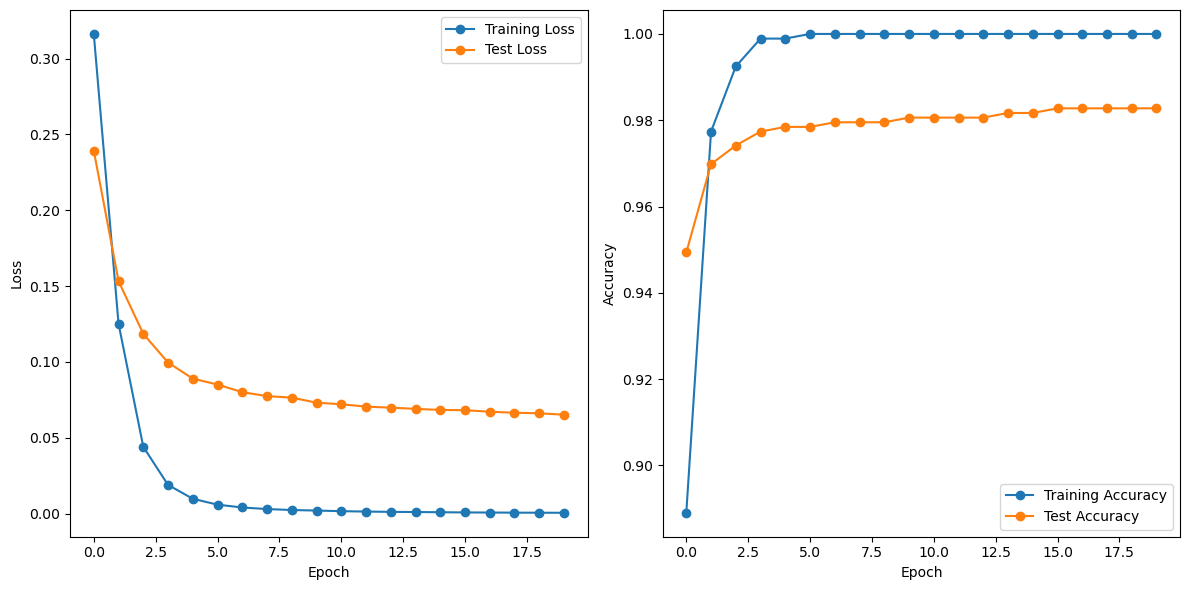

In [13]:
# グラフの作成
plt.figure(figsize=(12, 6))

# トレーニングおよびバリデーションの損失をプロット
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Test Loss', marker='o')
# plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# トレーニングおよびバリデーションの精度をプロット
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', marker='o')
plt.plot(val_accs, label='Test Accuracy', marker='o')
# plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# グラフの表示
plt.tight_layout()
plt.savefig(f'image/graph_{Ising_model}_{neural_network}_2.png')  # ファイル名を適切に指定
plt.show()


In [14]:
# for i in range(0, 900, 200):
#     A = val_data_tensor[i].unsqueeze(0)
#     B = val_labels_tensor[i]
#     C = val_betas_tensor[i]

#     print("No.", i)
#     print(model(A))
#     print(B)
#     print(C)

0.9 3.708975e-05 0.999958
0.85 3.780466e-05 0.9999575
0.8 3.837115e-05 0.999957
0.75 3.9229108e-05 0.9999562
0.7 4.286862e-05 0.999952
0.65 5.0133745e-05 0.9999432
0.6 5.5842153e-05 0.99993837
0.55 8.133142e-05 0.99991006
0.5 0.00016345855 0.99981767
0.47 0.00692101 0.993264
0.42 0.8609023 0.14529933
0.4 0.92672646 0.07641801
0.35 0.8773423 0.11999644
0.3 0.9472703 0.058273993
0.25 0.9270302 0.07354967
0.2 0.93352205 0.06427406
0.15 0.9263073 0.07616935
0.1 0.9048321 0.08554365
0.05 0.93080527 0.07349757
0.0 0.9282483 0.07049305


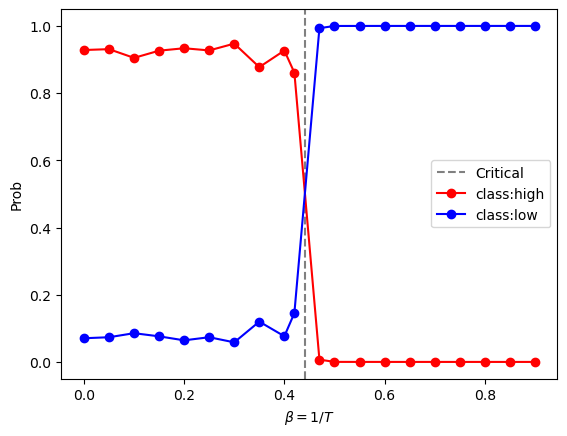

In [15]:
# 各逆温度での予測(確率)を可視化
xs = []
y1s = []
y2s = []
Ndatamax = 900
Nsameclass = 45
for ii in range(0, Ndatamax, Nsameclass):
    val_data = val_data_tensor
    res = model(val_data[ii : ii+Nsameclass])
    x = val_betas[ii]
    y1 = np.mean(res.detach().numpy().T[0])
    y2 = np.mean(res.detach().numpy().T[1])    
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    print(x, y1, y2)
plt.axvline(x=betacr, ymin=0, ymax=1, ls="dashed", color="gray", label="Critical")
plt.plot(xs, y1s, label="class:high", marker="o", color="red")
plt.plot(xs, y2s, label="class:low", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$\beta = 1/T$")
plt.ylabel(r"Prob")
# 図をファイルとして保存
plt.savefig(f'image/plot_{Ising_model}_{neural_network}.png')  # ファイル名を適切に指定
plt.show()

以下は Ising_model = square の場合のみ実行

正方イジング模型のスピン配位で学習したモデルに対して三角イジング模型のスピン配位データを入力して分類結果を求めてみる

0.54 3.9307994e-05 0.99995583
0.51 3.9307994e-05 0.99995583
0.48 4.065581e-05 0.9999546
0.45 4.217883e-05 0.999953
0.42 4.7619917e-05 0.99994653
0.39 5.738775e-05 0.99993515
0.36 7.3795694e-05 0.99991745
0.33 0.00014458662 0.999845
0.31 0.00022765117 0.99974704
0.29 0.010473566 0.9887161
0.25 0.95787054 0.044812176
0.23 0.95593256 0.049266037
0.21 0.9107903 0.09321237
0.18 0.9407557 0.062069073
0.15 0.9454848 0.058454253
0.12 0.9186942 0.08007688
0.09 0.9318231 0.07287237
0.06 0.91436934 0.082225576
0.03 0.9354667 0.06787435
0.0 0.9282483 0.07049305


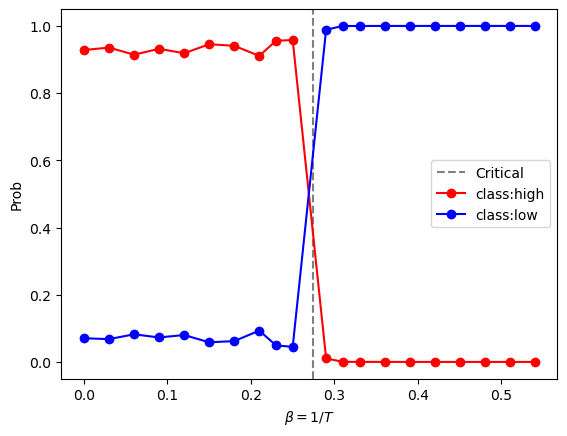

In [16]:
# 各逆温度での予測(確率)を可視化
xs = []
y1s = []
y2s = []
Ndatamax = 900
Nsameclass = 45
if Ising_model == 'square':
    for ii in range(0, Ndatamax, Nsameclass):
        val_data = val_data_tri_tensor  # 三角イジングのデータ
        res = model(val_data[ii : ii+Nsameclass])
        x = val_betas_tri[ii]
        y1 = np.mean(res.detach().numpy().T[0])
        y2 = np.mean(res.detach().numpy().T[1])    
        xs.append(x)
        y1s.append(y1)
        y2s.append(y2)
        print(x, y1, y2)
    plt.axvline(x=betacr_tri, ymin=0, ymax=1, ls="dashed", color="gray", label="Critical")
    plt.plot(xs, y1s, label="class:high", marker="o", color="red")
    plt.plot(xs, y2s, label="class:low", marker="o", color="blue")
    plt.legend()
    plt.xlabel(r"$\beta = 1/T$")
    plt.ylabel(r"Probability")
    # 図をファイルとして保存
    plt.savefig(f'image/plot_{Ising_model}_{neural_network}_tridata.png')  # ファイル名を適切に指定
    plt.show()